In [2]:
import numpy as np
import pandas as pd
import sklearn as sk
import sklearn.preprocessing
import tensorflow as tf
from tensorflow.keras.layers import *
import sklearn.metrics
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import math 
rcParams['figure.figsize']=20,10

dataset = pd.read_csv('BTC-USD.csv')

dataset.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,13/12/2016,780.646973,788.460022,777.961975,780.556030,780.556030,81645600.0
1,14/12/2016,780.005005,782.033997,776.838989,781.481018,781.481018,75979000.0
2,15/12/2016,780.070007,781.434998,777.802002,778.088013,778.088013,81580096.0
3,16/12/2016,778.963013,785.031982,778.963013,784.906982,784.906982,83608200.0
4,17/12/2016,785.166016,792.508972,784.864014,790.828979,790.828979,78989800.0


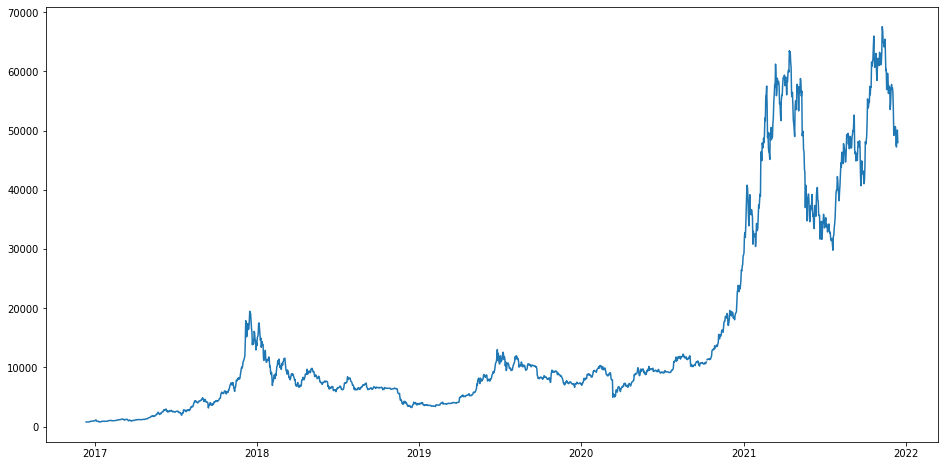

In [3]:
dataset["Date"]=pd.to_datetime(dataset.Date,format = "%d/%m/%Y")
dataset.index = dataset['Date']
    
plt.figure(figsize=(16,8))
#plt.legend
plt.plot(dataset["Close"],label='Close Price history') # arxiko diagramma dedomenwn

Epoch 1/20
29/29 [==============================] - 4s 66ms/step - loss: 0.0023 - val_loss: 0.0235
Epoch 2/20
29/29 [==============================] - 1s 44ms/step - loss: 3.7890e-04 - val_loss: 0.0134
Epoch 3/20
29/29 [==============================] - 1s 44ms/step - loss: 2.6413e-04 - val_loss: 0.0065
Epoch 4/20
29/29 [==============================] - 1s 44ms/step - loss: 2.2959e-04 - val_loss: 0.0052
Epoch 5/20
29/29 [==============================] - 1s 44ms/step - loss: 2.0793e-04 - val_loss: 0.0063
Epoch 6/20
29/29 [==============================] - 1s 44ms/step - loss: 1.9769e-04 - val_loss: 0.0156
Epoch 7/20
29/29 [==============================] - 1s 46ms/step - loss: 1.9434e-04 - val_loss: 0.0103
Epoch 8/20
29/29 [==============================] - 1s 45ms/step - loss: 1.6865e-04 - val_loss: 0.0153
Epoch 9/20
29/29 [==============================] - 1s 46ms/step - loss: 1.8628e-04 - val_loss: 0.0126
Epoch 10/20
29/29 [==============================] - 1s 47ms/step - loss: 1.5

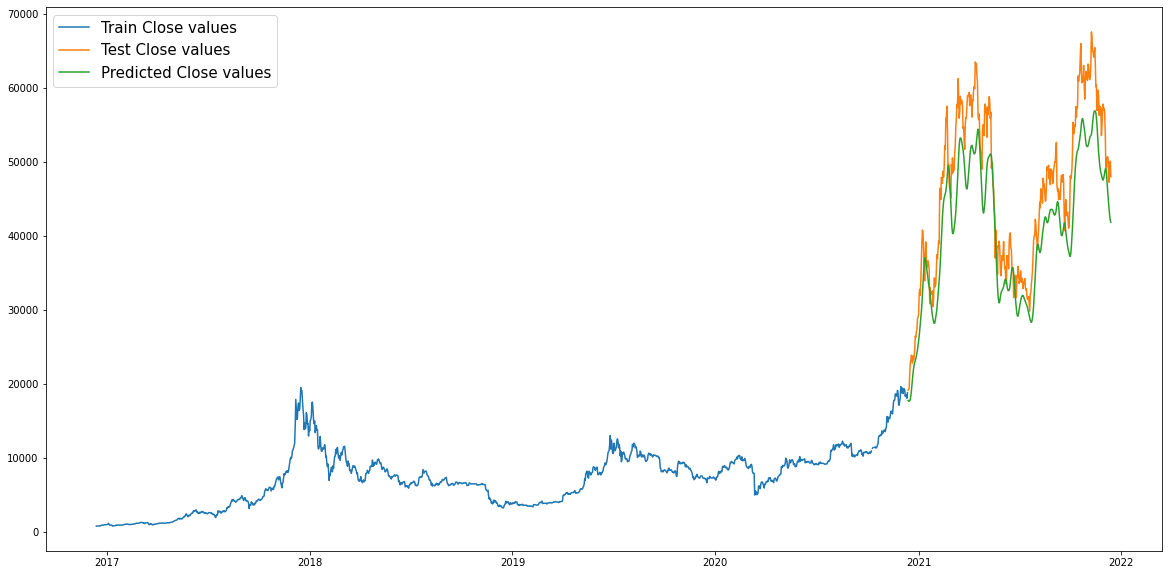

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_21 (LSTM)              (None, 50, 50)            10400     
                                                                 
 lstm_22 (LSTM)              (None, 50, 50)            20200     
                                                                 
 lstm_23 (LSTM)              (None, 50)                20200     
                                                                 
 dense_7 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________
None


In [78]:
new_dataset = pd.DataFrame(index=range(0,len(dataset)),columns=['Date','Close'])

for i in range(0,len(dataset)):
    new_dataset["Date"][i] = dataset['Date'][i]
    new_dataset["Close"][i] = dataset["Close"][i]    
   
# data normalization
scaler = sk.preprocessing.MinMaxScaler(feature_range=(0,1))
new_dataset.index=new_dataset.Date
new_dataset.drop("Date",axis=1,inplace=True)
final_dataset = new_dataset.values


train_data = final_dataset[0:1461,:] # 80% training data
valid_data = final_dataset[1461:,:]  # 20% testing data 



scaler=sk.preprocessing.MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(final_dataset)

# remove NaN values
scaled_data = scaled_data[~np.isnan(scaled_data)]
scaled_data = scaled_data.reshape(-1,1)

# pairnoume ta training data, 50 mini batches
x_train_data,y_train_data=[],[]
for i in range(50,len(train_data)):
    x_train_data.append(scaled_data[i-50:i,0])
    y_train_data.append(scaled_data[i,0])
    
    
x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)
x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))

# etoimasia twn testing data. Epishs pairnoume pali 50 mini batches

test_data = new_dataset[len(new_dataset)-len(valid_data)-50:].values
test_data = test_data.reshape(-1,1)
test_data = scaler.transform(test_data)


X_test = []
y_test = []
for i in range(50,test_data.shape[0]):
    X_test.append(test_data[i-50:i,0])
    y_test.append(test_data[i,0])
    
X_test = np.array(X_test)
y_test = np.array(y_test)

X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

    
# RNN implementation

model=tf.keras.Sequential()
model.add(LSTM(units = 50,return_sequences = True,input_shape=(x_train_data.shape[1],1))) # input layer
model.add(LSTM(units = 50,return_sequences = True)) # 1o hidden layer
model.add(LSTM(units = 50)) # 2o hidden layer
model.add(Dense(units = 1)) # output layer

model.compile(loss='mean_squared_error',optimizer='adam')
model_log = model.fit(x_train_data,y_train_data,validation_data = (X_test,y_test) ,epochs=20,batch_size=50)


ypred = model.predict(X_test)
ypred = scaler.inverse_transform(ypred)


# dhmiourgia diagrammatos gia epivevaiwsh provlepsewn tou montelou
train_data = new_dataset[:1461].copy()
test_data = new_dataset[1461:].copy()
test_data['Predictions'] = ypred


plt.plot(train_data['Close'], label = "Train Close values")
plt.plot(test_data[['Close']] , label = "Test Close values")
plt.plot(test_data[['Predictions']], label = "Predicted Close values")
plt.legend(loc='upper left', fontsize=15)
plt.show()

print(model.summary())

In [79]:
print("R2 score is : ", sklearn.metrics.r2_score(valid_data,ypred))
print("RMSE is : ", math.sqrt(sklearn.metrics.mean_squared_error(test_data['Close'],test_data['Predictions'])))

R2 score is :  0.679661282142207
RMSE is :  6268.343478417583


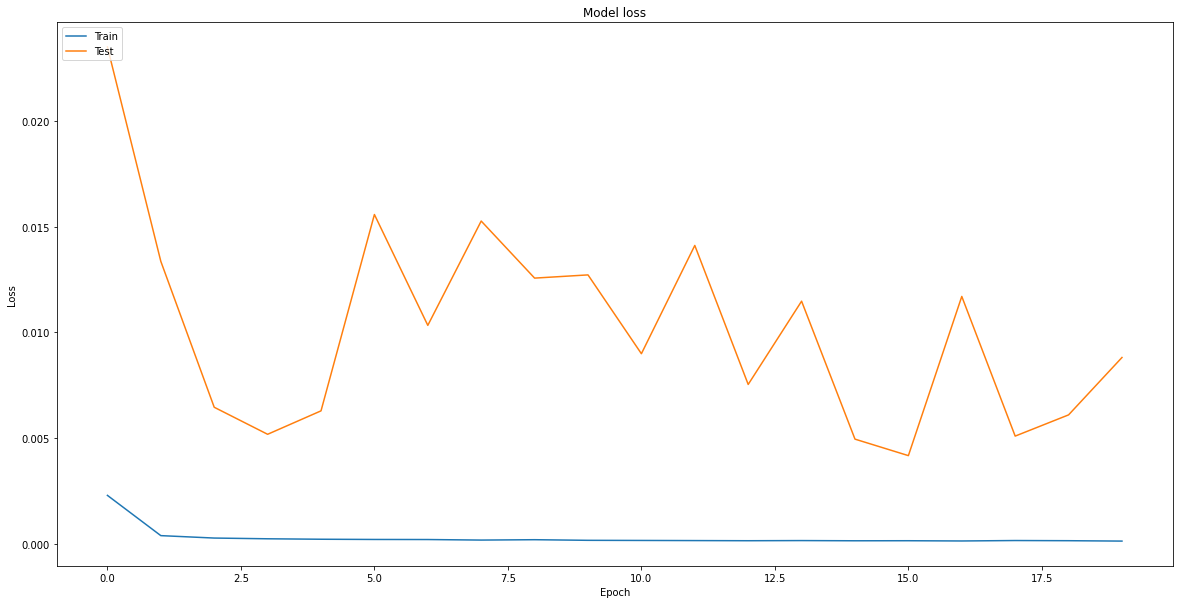

In [80]:
# model loss and val loss diagrams

plt.plot(model_log.history['loss'])
plt.plot( model_log.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [82]:
# Predict the next day (14/12/2021 gia to dataset mas)
# pairnw tis 50 teleytaies meres
test_data_last = []


# pairnw thn teleytaia penhntada
test_data_last = X_test[365]

nextDayPred = model.predict(test_data_last)
nextDayPred = scaler.inverse_transform(nextDayPred)
# epeidh to montelo mas provlepei allh mia 50ada pairnoume mono thn prwth timh h opoia einai h timh ths 14/12
# dhladh ths epomenhs meras
print("14/12/2021 close price : " , nextDayPred[0] * 10)

14/12/2021 close price :  [46802.816]
